# Implementing a Neural Network from Scratch

---
## Loading the Data
We are going to use the Keras MNIST data. The following steps should look familiar.

In [2]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

# Reshape
train_data = train_data.reshape(60000, 28*28)
test_data = test_data.reshape(10000, 28*28)

# Scale
train_data = train_data.astype('float32') / 255
test_data = test_data.astype('float32') / 255

# One-hot Encode
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Check Shapes
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

# Train / Val / Test
x_val = train_data[:10000]
x_train = train_data[10000:]
y_val = train_labels[:10000]
y_train = train_labels[10000:]

(60000, 784)
(10000, 784)
(60000, 10)
(10000, 10)


---
## Experiment

In [4]:
import numpy as np

def init_parameters(sizes):
    """Initializes a network with the given layer sizes."""
    parameters = {}
    for l in range(1, len(sizes)):
        parameters['W' + str(l)] = np.random.randn(sizes[l], sizes[l-1]) * np.sqrt(2/sizes[l-1])
        parameters['b' + str(l)] = np.zeros((sizes[l], 1))
    return parameters

In [322]:
def feed_forward_step(A_prev, W, b, activation):
    """Performs a single feed forward step with relu activation."""
    Z = np.dot(W, A_prev) + b
    
    if activation == 'relu':
        A = np.maximum(Z, 0)
        
    if activation == 'softmax':
        shiftx = Z - np.max(Z)
        exps = np.exp(shiftx)
        A = exps / np.sum(exps)
    
    cache = (W, A_prev, b, Z, A)
    return A, cache 

def feed_forward(parameters, X):
    A = X 
    L = len(parameters) // 2
    caches = []
    
    # Use ReLU Activation on all hidden layers
    for l in range(1, L):
        A_prev = A
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        A, cache = feed_forward_step(A_prev, W, b, 'relu')
        caches.append(cache)
        
    # Use Softmax Activation on the output layer
    W = parameters['W' + str(L)]
    b = parameters['b' + str(L)]
    A, cache = feed_forward_step(A, W, b, 'softmax')
    caches.append(cache)
    
    return A, caches
        

In [181]:
def back_prop_step(dA, cache, activation):
    """Perform backpropagation for a single layer."""
    (W, A_prev, b, Z, A) = cache
    m = A_prev.shape[1]
    
    if activation == 'relu':
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        
    if activation == 'softmax':
        s = 1 / (1+np.exp(-Z))
        dZ = dA * s * (1-s)
        
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

def back_prop(AL, Y, caches):
    """Performs backward propagation."""
    gradients = {} 
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    eps = 1e-8
    
    # Initialize backpropagation
    dAL = - (np.divide(Y, AL + eps) - np.divide(1 - Y, 1 - AL + eps)) 

    # Output layer 
    cache = caches[L-1]
    gradients['dA' + str(L-1)], gradients['dW' + str(L)], gradients['db' + str(L)] = back_prop_step(dAL, cache, 'softmax')
    
    # All other layers 
    for l in reversed(range(L-1)):
        cache = caches[l]
        dA = gradients['dA' + str(l + 1)]
        dA_prev, dW, db = back_prop_step(dA, cache, 'relu')
        gradients['dA' + str(l)] = dA_prev
        gradients['dW' + str(l + 1)] = dW
        gradients['db' + str(l + 1)] = db
    
    return gradients

In [12]:
def compute_cost(Y, AL):
    """Computes the cost using the CE cost function."""
    m = Y.shape[1]
    eps = 1e-8
    cost = (-1/m) * np.sum(np.multiply(np.log(AL + eps), Y) + np.multiply(np.log((1-AL) + eps),(1-Y)))
    return np.squeeze(cost)

In [29]:
def get_minibatch(X, Y, batch_size):
    """Generator for mini batches."""
    permutation = np.random.permutation(X.shape[1])
    for k in range(0, X.shape[1], batch_size):
        batch_columns = permutation[k:k+batch_size]
        X_mini = X[:,batch_columns]
        Y_mini = Y[:,batch_columns]
        yield (X_mini, Y_mini)

In [319]:
def update_parameters(parameters, grads, learning_rate):
        """Updates the weights and biases with the given gradients."""
        L = len(parameters) // 2

        for l in range(L):
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

        return parameters

In [323]:
def train(parameters, X, Y, epochs, lr, batch_size=128, print_cost=True):
    for i in range(1, epochs+1):
        cost = 0
        for mini_X, mini_Y in get_minibatch(X.T, Y.T, batch_size):
            A, caches = feed_forward(parameters, mini_X)
            cost += compute_cost(mini_Y, A)
            grads = back_prop(A, mini_Y, caches)
            parameters = update_parameters(parameters, grads, learning_rate=lr)
        if print_cost and i % 5 == 0:
            print("Cost after epoch %i: %f" %(i, cost))

In [324]:
# params = init_parameters([784, 30, 10])
train(params, x_train, y_train, 50, 0.05)

Cost after epoch 5: 7230.635238
Cost after epoch 10: 7230.635238
Cost after epoch 15: 7230.923062
Cost after epoch 20: 7228.044830
Cost after epoch 25: 7231.498708
Cost after epoch 30: 7229.196123
Cost after epoch 35: 7229.196123
Cost after epoch 40: 7227.584313
Cost after epoch 45: 7229.599075
Cost after epoch 50: 7232.362177


In [270]:
def predict(params, X):
    out, _ = feed_forward(params, X)
    predictions = np.argmax(out, axis=0)
    return predictions
    
def accuracy(params, X, Y):
    targets = np.argmax(Y, axis=0)
    predictions = predict(params, X)
    return np.mean(predictions == targets)

In [271]:
print(accuracy(params, x_train.T, y_train.T))
print(accuracy(params, x_val.T, y_val.T))

0.98044
0.9603


## Generating Experiment

In [272]:
image = np.random.randn(1, 784) * 0.01
image_copy = np.copy(image)

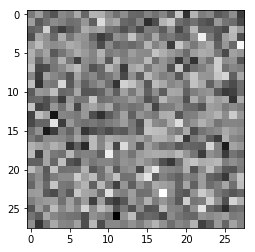

In [273]:
import matplotlib.pyplot as plt

plt.imshow(image.reshape(28,28), cmap='gray')
plt.show()

In [304]:
def update_image(image, grads, learning_rate):
        """Updates the weights and biases with the given gradients."""
        image = image - (learning_rate * grads["dA0"])
        return image

In [311]:
label = 9
label_vector = np.zeros((1,10))
label_vector[0,label] = 1

(10,)
(10,)
(784,)
(784,)


In [314]:
def generate_image(parameters, image, Y, epochs, lr, batch_size=1, display=True):
    for i in range(1, epochs+1):
        A, caches = feed_forward(parameters, image)
        grads = back_prop(A, label_vector, caches)
        image = update_image(image, grads, learning_rate=lr)
        if display and i % 10000 == 0:
            cost = compute_cost(Y, A)
            print("Image after epoch", str(i))
            print(cost)
            plt.imshow(image.reshape(28,28), cmap='gray')
            plt.show()
    return image

Image after epoch 10000
0.00012632240930917298


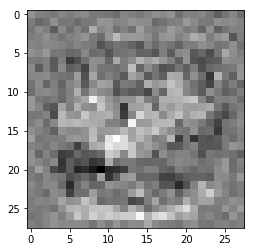

Image after epoch 20000
6.336219484029369e-05


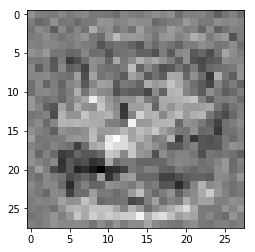

Image after epoch 30000
4.226515486532047e-05


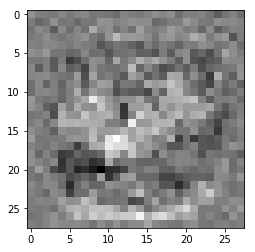

Image after epoch 40000
3.1695551137831506e-05


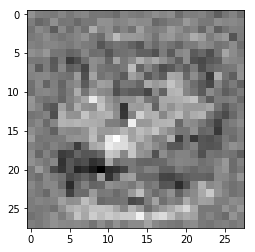

Image after epoch 50000
2.5346980726067273e-05


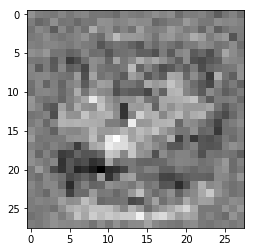

Image after epoch 60000
1.9280712204040458e-05


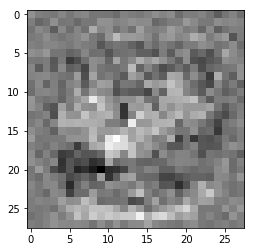

Image after epoch 70000
1.554987930033587e-05


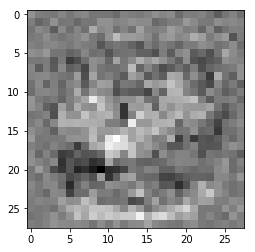

Image after epoch 80000
1.3112639233376109e-05


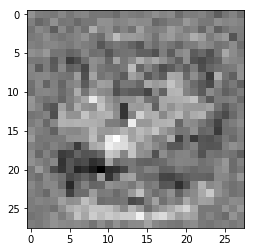

Image after epoch 90000
1.136717084674593e-05


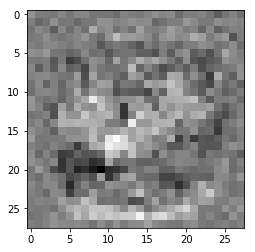

Image after epoch 100000
1.00452539577862e-05


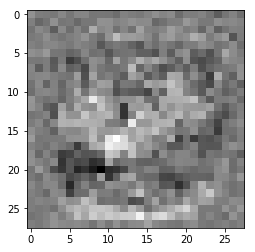

In [315]:
image_one = generate_image(params, image.T, label_vector.T, 100000, lr=0.1)

In [316]:
A, caches = feed_forward(params, image.T)
grads = back_prop(A, label_vector.T, caches)

In [317]:
# print(grads.keys())
# print(grads['dA0'])
A, caches = feed_forward(params, image.T)
print(label_vector)
print(A)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0.00766546]
 [0.12846584]
 [0.08333786]
 [0.01092673]
 [0.19867898]
 [0.34998709]
 [0.07564978]
 [0.05190939]
 [0.00807232]
 [0.05622602]]
